# Laborator 4

In [1]:
import requests
import mwparserfromhell

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

import re

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuinoschi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract documents from Wikipedia for three different topics.

In [2]:
topics = {'astronomy' : ['Planet', 'Galaxy', 'Black hole', 'Nebula'], 
          'food': ['Spaghetti', 'Milk', 'Pizza'], 
          'physics': ['Quantum mechanics', 'Gravity', 'String theory']}

In [3]:
def get_document(title: str):
    response = requests.get(
        'https://en.wikipedia.org/w/api.php',
        params={
            'action': 'query',
            'format': 'json',
            'titles': title,
            'prop': 'revisions',
            'rvprop': 'content'
        }).json()
    page = next(iter(response['query']['pages'].values()))
    wikicode = page['revisions'][0]['*']
    parsed_wikicode = mwparserfromhell.parse(wikicode)
    return parsed_wikicode.strip_code()

In [4]:
def clean_wiki_text(text: str):
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = re.sub("{{[\w+\s*\|\,]*}}", "", text)
    text = re.sub("\[\[(.*?)\]\]", "", text)
    text = re.sub("thumb\|[\w+\|\s]*", "", text)
    text = re.sub("\<ref\>(.*'?)\<\/ref\>", "", text)
    text = re.sub('Category:[w+\s]*', "", text)
    text = re.sub('[0-9]*px\|', "", text)
    text = re.sub('[\(\)]+', "", text)
    return text

In [5]:
documents = []
for topic, titles in topics.items():
    for title in titles:
        text = clean_wiki_text(get_document(title))
        documents.append(text)
        print(text[:50])

 Mercury Venus Earth Mars Jupiter Saturn Uranus Ne
A galaxy is a gravitationally bound system of star


A black hole is a region of spacetime where grav
 


A nebula Latin for 'cloud' or 'fog';Nebula, On
Spaghetti  is a long, thin, solid, cylindrical pas
.

Milk is a nutrient-rich liquid food produced by
Pizza ,  is a dish of  Italian origin consisting o


Quantum mechanics is a fundamental theory in phy


Gravity , or gravitation, is a natural phenomeno
In physics, string theory is a theoretical framewo


In [6]:
print(len(documents))

10


## Use text preprocessing techniques (stemming/lematization, stop words removal) and create the bag-of-words and TF-IDF vectorizations

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
def lemmaSentence(sentence):
    token_words=word_tokenize(sentence)
    lemma_sentence=[]
    for word in token_words:
        word = word.lower()
        if word not in stop_words and word not in [',','.','-','?','!', ':', "''", "'s", "``", "'", ";", "%"]:
            lemma_sentence.append(lemmatizer.lemmatize(word))
            lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [9]:
for index in range (0, len(documents)):
    documents[index] = lemmaSentence(documents[index])

In [10]:
documents[0][:50]

'mercury venus earth mar jupiter saturn uranus nept'

### Bag of words encoding

In [11]:
wordfreq = {}
for sentence in documents:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [12]:
list(wordfreq.keys())[:25]

['mercury',
 'venus',
 'earth',
 'mar',
 'jupiter',
 'saturn',
 'uranus',
 'neptunethe',
 'eight',
 'known',
 'planet',
 'solar',
 'system',
 'terrestrial',
 'giant',
 'gas',
 'neptune',
 'ice',
 'shown',
 'order',
 'sun',
 'true',
 'color',
 'size',
 'scale']

In [13]:
len(wordfreq.keys())

8062

In [14]:
encodings = []
for document in documents:
    encoding = []
    for word in nltk.word_tokenize(document):
        encoding.append(wordfreq[word])
    encodings.append(encoding)

In [15]:
encodings[0][:50]

[46,
 41,
 116,
 35,
 62,
 34,
 23,
 1,
 14,
 109,
 357,
 68,
 169,
 9,
 357,
 46,
 41,
 116,
 35,
 37,
 357,
 62,
 34,
 69,
 37,
 23,
 23,
 9,
 37,
 14,
 24,
 71,
 14,
 7,
 51,
 40,
 357,
 19,
 53,
 22,
 320,
 35,
 15,
 46,
 27,
 4,
 157,
 46,
 27,
 20]

#### Creating the encoding as a sparse array with the length of the dictionary. We do this in order to have the same length for each document.

In [16]:
dim = len(wordfreq.keys())

sparse_bag_of_words_encodings = np.zeros((len(documents), dim))

for index_document in range (0, len(documents)):
    document = documents[index_document]
    document_tokens = nltk.word_tokenize(document)
    for index_token in range (0, dim):
        token = list(wordfreq.keys())[index_token]
        if token in document_tokens:
            sparse_bag_of_words_encodings[index_document, index_token] = wordfreq[token]

sparse_bag_of_words_encodings[0]

array([ 46.,  41., 116., ...,   0.,   0.,   0.])

In [17]:
documents[0][:50]

'mercury venus earth mar jupiter saturn uranus nept'

### TF-IDF encoding

In [18]:
vectorizer = TfidfVectorizer()
sparse_tf_idf_encodings = vectorizer.fit_transform(documents)
sparse_tf_idf_encodings.shape

(10, 7378)

In [19]:
sparse_bag_of_words_encodings.shape

(10, 8062)

In [20]:
sparse_tf_idf_encodings.shape

(10, 7378)

## Functions for usage

In [21]:
def plot_top_words(model, feature_names):
    fig, axes = plt.subplots(1, 3, figsize=(12, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -10 - 1 : -1]
        # print(top_features_ind)
        # print(feature_names.shape)
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [22]:
def plot_word_cloud(model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.components_

    fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        top_features_ind = topics[i].argsort()[: -10 - 1 : -1]
        top_features = [np.array(list(wordfreq.keys()))[i] for i in top_features_ind]
        weights = topics[i][top_features_ind]
        topic_words = dict(zip(top_features,weights))
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

## Latent Semantic Analysis with SVD

### For the **bag of words encoding**

In [23]:
lsi_model = TruncatedSVD(n_components=3)
lsi_Z = lsi_model.fit_transform(sparse_bag_of_words_encodings)
print(lsi_Z.shape)

(10, 3)


In [24]:
feature_names = np.array(list(wordfreq.keys()))

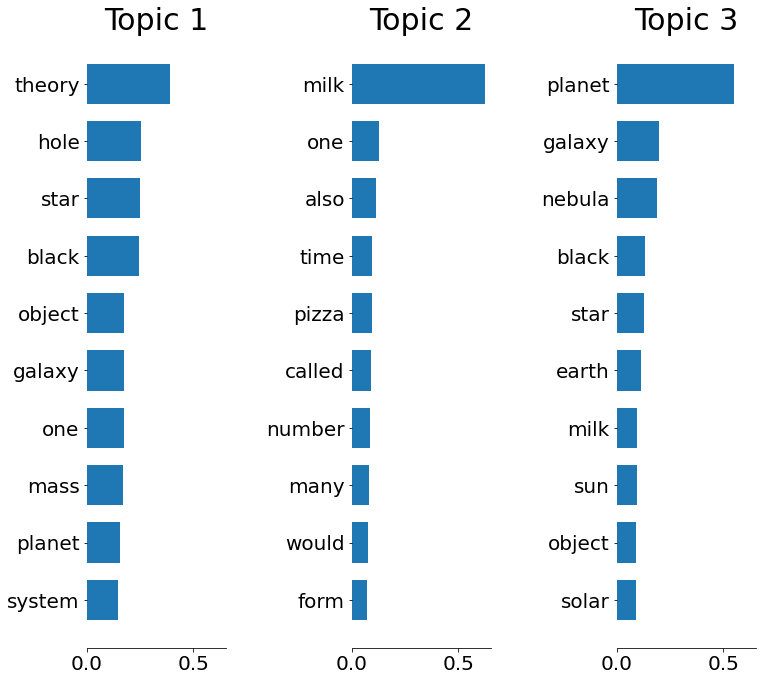

In [25]:
plot_top_words(lsi_model, feature_names )

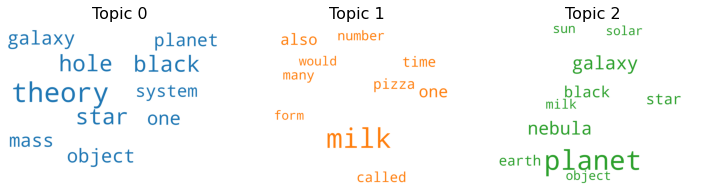

In [26]:
plot_word_cloud(lsi_model)

### For the **TF-IDF encoding**

In [27]:
lsi_model = TruncatedSVD(n_components=3)
lsi_Z = lsi_model.fit_transform(sparse_tf_idf_encodings)
print(lsi_Z.shape)

(10, 3)


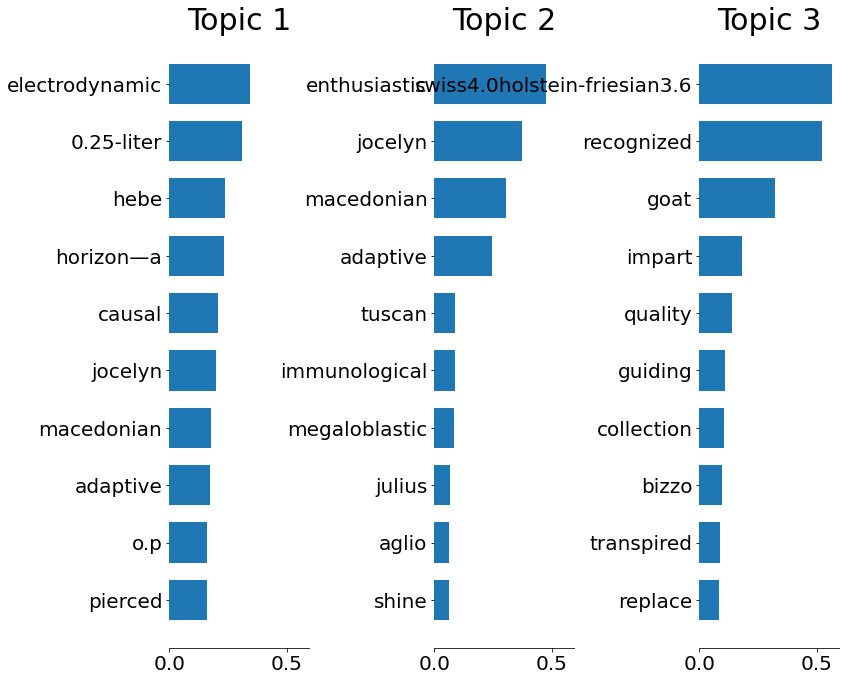

In [28]:
plot_top_words(lsi_model, feature_names )

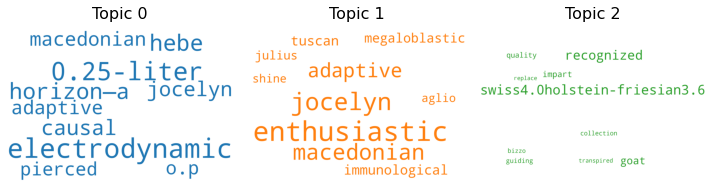

In [29]:
plot_word_cloud(lsi_model)

## Non-negative matrix factorization

### For the **bag of words encoding**

In [30]:
nmf_model = NMF(n_components=3)
nmf_Z = nmf_model.fit_transform(sparse_bag_of_words_encodings)
print(nmf_Z.shape)
print(nmf_Z[0])

(10, 3)
[ 6.71792427  6.83597757 22.76697094]


C:\Users\abuinoschi\Anaconda3\envs\rn4nlp\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


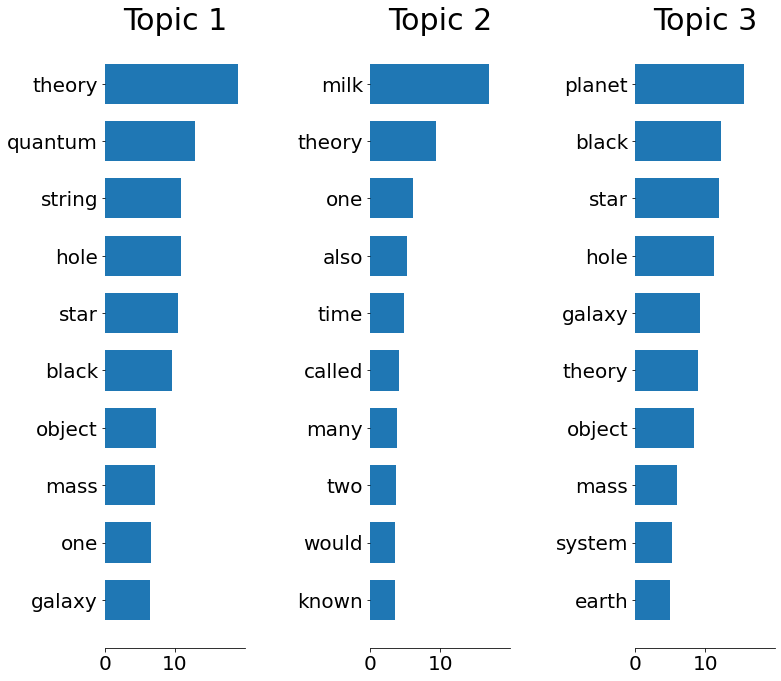

In [31]:
plot_top_words(nmf_model, feature_names )

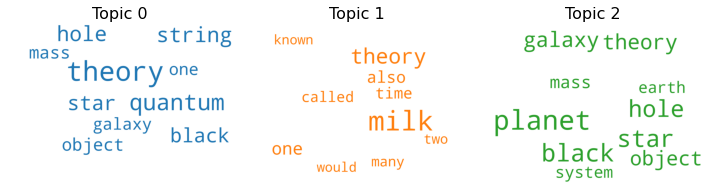

In [32]:
plot_word_cloud(nmf_model)

### For the **TF-IDF encoding**

In [33]:
nmf_model = NMF(n_components=3)
nmf_Z = nmf_model.fit_transform(sparse_tf_idf_encodings)
print(nmf_Z.shape)
print(nmf_Z[0])

(10, 3)
[0.0132581  0.57219905 0.00222794]


C:\Users\abuinoschi\Anaconda3\envs\rn4nlp\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


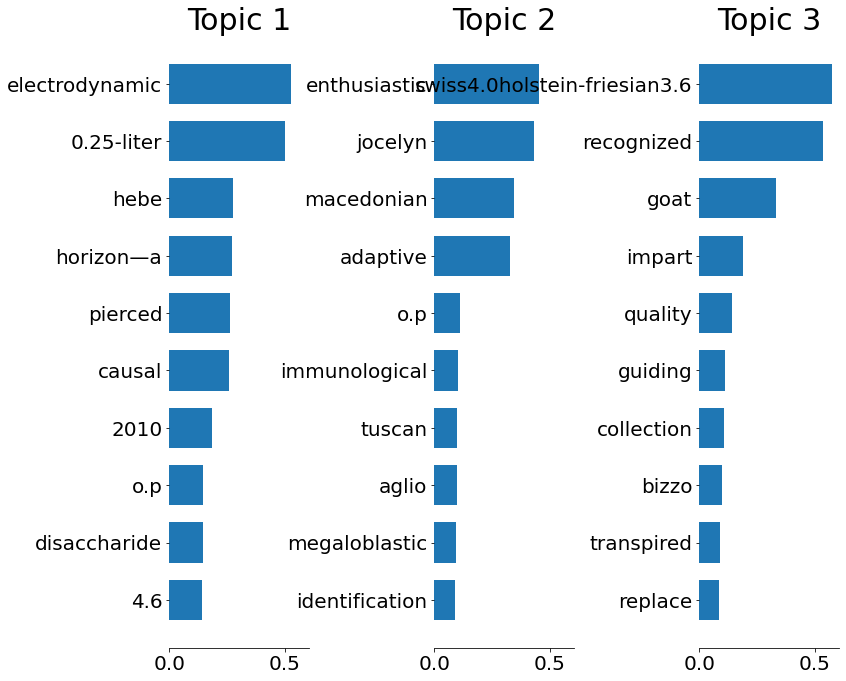

In [34]:
plot_top_words(nmf_model, feature_names )

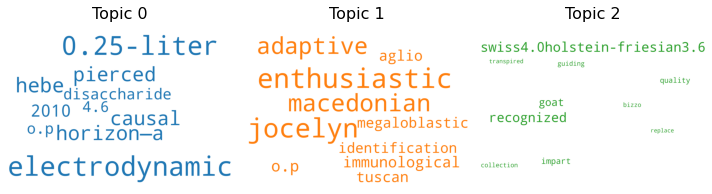

In [35]:
plot_word_cloud(nmf_model)

## LDA

### For the **bag of words encoding**

In [36]:
lda_model = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(sparse_bag_of_words_encodings)
print(lda_Z.shape)
print(lda_Z[0])

(10, 3)
[9.99966764e-01 1.61727100e-05 1.70637696e-05]


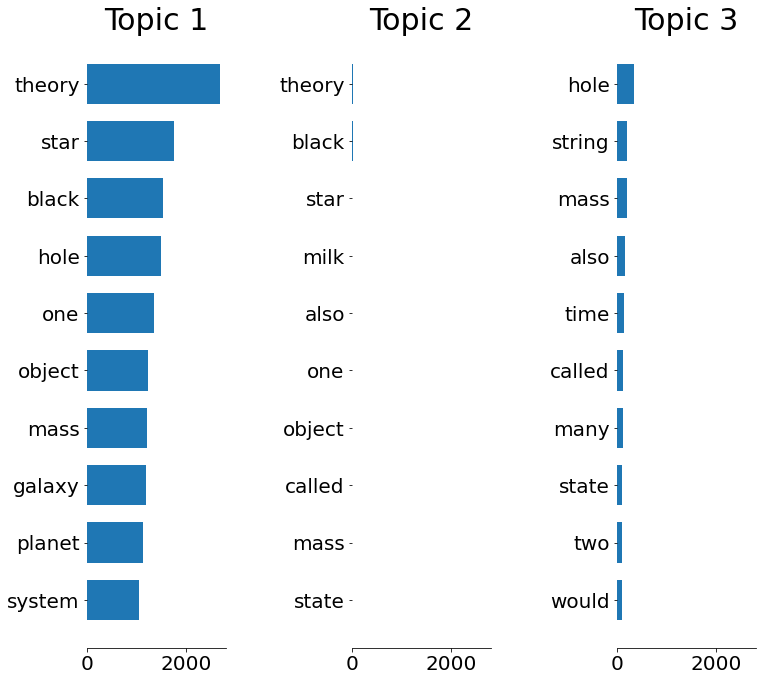

In [37]:
plot_top_words(lda_model, feature_names )

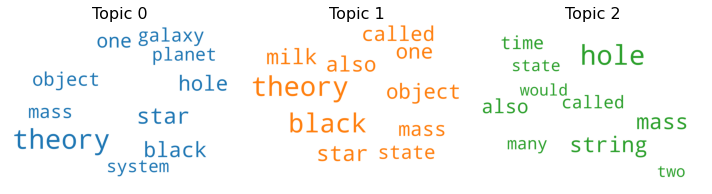

In [38]:
plot_word_cloud(lda_model)

### For the **TF-IDF encoding**

In [39]:
lda_model = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(sparse_tf_idf_encodings)
print(lda_Z.shape)
print(lda_Z[0])

(10, 3)
[0.02639256 0.02609715 0.94751028]


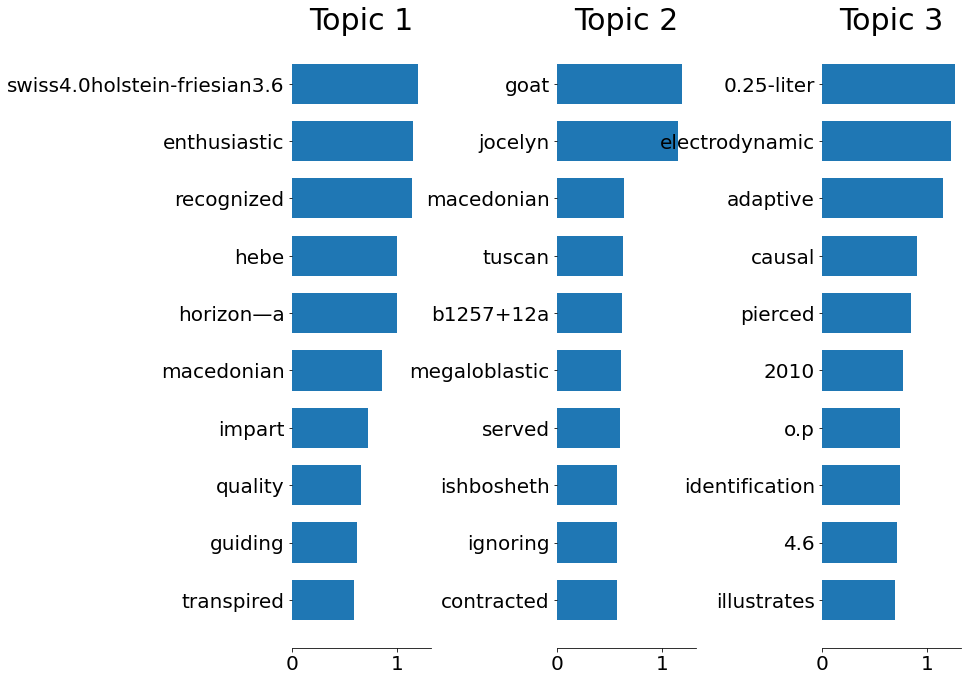

In [40]:
plot_top_words(lda_model, feature_names )

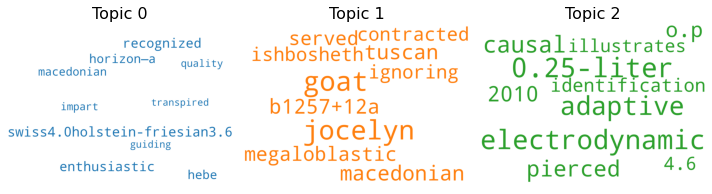

In [41]:
plot_word_cloud(lda_model)